# Index - Model Preprocessing & Processing

## I. Model Preprocessing (inc some Formatting)
A. OHE  
B. Train Test Split  
C. CountVectorizer  
D. Odds Ratio  

## II. Modeling - Logistic Regression

## III. Model Evaluation

## Editor Notes

This is an iterated 2nd edition of this notebook. Changes made:

Model Preprocessing / Addtl Formatting
- Combine english languages together
- Remove Split Tags section here, processing has already been done in Cleaning, Formatting 2nd Edition
- OHE Month and Hour
- Make sure Month and Hour in train set data - done

Modeling
- stem
- ftfy for characters
- optimize through pipeline - use notes from 9/12

I will leave notes as to accuracies of previous models so I can keep track of how the model improves with each iteration.

Before I update the modeling notebook, I will update the relevant Preprocessing sections (Split Tags, Hour, OHE Hour and Month) and run the model to see if the model improved after Cleaning, Formatting 2nd Edition.

In [486]:
#import libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
from datetime import datetime, timedelta

#modeling
import nltk #natural language tool kit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [487]:
#df = pd.read_csv('../data/data_vids_09.12.2024.csv', index_col = 0)

df = pd.read_csv('../data/data_vids_09.13.2024.csv', index_col = 0)

In [488]:
df.shape
#1690 vids x 29 cols to start

(1665, 31)

In [489]:
df.head()

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,Likes per Month,Category,No Description,No Tags,Month Published,Tag Count,Hour Published,Split Tags,Views_mo_High,Likes_mo_High
0,https://www.youtube.com/watch?v=WBeMRU1Tbgs,The Perfect ASMR Video,Well... that's up for you to decide!! How did ...,2022-09-10 22:00:19+00:00,UCE6acMV3m35znLcf0JGNn7Q,Gibi ASMR,"gibi, asmr, gibi asmr, perfect, video, for sle...",24,en,PT1H12M56S,...,3549.516369,Entertainment,0,0,9,14,22,gibi asmr gibiasmr perfect video forsleep rela...,1,1
1,https://www.youtube.com/watch?v=vvcUJEQnen4,ASMR Victorian Medical Roleplay 🩺 Medical Exam,Meet with the remarkable Doctor Cosmos and his...,2022-09-13 19:45:00+00:00,UC20BrZXv7OC6JyALCZN-0Ig,Tinglesmith ASMR,,22,en,PT26M3S,...,1154.784483,People & Blogs,0,1,9,0,19,,1,0
2,https://www.youtube.com/watch?v=BNxAGgvb60w,The Tingle Writer 🖋️ASMR (Cinematic Roleplay),"The Tingle Writer, an #ASMR #Cinematic #Rolepl...",2022-09-25 21:00:11+00:00,UC4d18IlLmw0utmVxIjSadLQ,Made In France ASMR,"asmr, sleep, binaural, satisfying, tingles, tr...",24,en,PT59M,...,4765.818139,Entertainment,0,0,9,36,21,asmr sleep binaural satisfying tingles trigger...,1,1
3,https://www.youtube.com/watch?v=UPn3GAzLwEw,Welcome Back Questionnaire (Dystopian ASMR),This is probably one of the most non-event ASM...,2022-09-10 20:00:05+00:00,UC4eO8gplCQQqD8yvuey1TxQ,Jimち ASMR,"Asmr, asmr for sleep, relaxing sounds, jim chi...",26,en,PT28M25S,...,154.255952,Howto & Style,0,0,9,13,20,Asmr asmrforsleep relaxingsounds jimchiasmr ji...,0,0
4,https://www.youtube.com/watch?v=fMIAKg68tMA,1 Hour Of ASMR Tingles For Deep Sleep,My longest video and biggest trigger assortmen...,2022-09-25 22:00:15+00:00,UCM5z4re0CofPJJTp1Uocb9Q,Safe Space ASMR,"1 hour asmr, one hour of asmr, one hour of asm...",22,en,PT1H14M13S,...,125.250117,People & Blogs,0,0,9,22,22,1hourasmr onehourofasmr onehourofasmrtingles 1...,0,0


In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 3954
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Video URL          1665 non-null   object 
 1   Title              1665 non-null   object 
 2   Description        1665 non-null   object 
 3   Published At       1665 non-null   object 
 4   Channel ID         1665 non-null   object 
 5   Channel Title      1665 non-null   object 
 6   Tags               1665 non-null   object 
 7   Category ID        1665 non-null   int64  
 8   Default Language   1665 non-null   object 
 9   Duration           1665 non-null   object 
 10  View Count         1665 non-null   int64  
 11  Like Count         1665 non-null   int64  
 12  Dislike Count      1665 non-null   int64  
 13  Favorite Count     1665 non-null   int64  
 14  Comment Count      1665 non-null   int64  
 15  Comments Disabled  1665 non-null   bool   
 16  Ratings Disabled   1665 

In [491]:
#need to convert Published At to datetime
#might not use?

# I. Model Preprocessing

## A. OHE

Columns to OHE:
- Category
- Default Language
- Month Published ???

Other
- Split tags

### 1. Category

Take top 6, leave rest as 'Other'

In [492]:
# Step 1: Identify the top 6 categories
top_n = 6
top_categories = df['Category'].value_counts().nlargest(top_n).index

# Step 2: Replace less frequent categories with 'Other'
df['Category Binned'] = df['Category'].apply(lambda x: x if x in top_categories else 'Other')

In [493]:
df[df['Category Binned'] != 'Other']

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,Category,No Description,No Tags,Month Published,Tag Count,Hour Published,Split Tags,Views_mo_High,Likes_mo_High,Category Binned
0,https://www.youtube.com/watch?v=WBeMRU1Tbgs,The Perfect ASMR Video,Well... that's up for you to decide!! How did ...,2022-09-10 22:00:19+00:00,UCE6acMV3m35znLcf0JGNn7Q,Gibi ASMR,"gibi, asmr, gibi asmr, perfect, video, for sle...",24,en,PT1H12M56S,...,Entertainment,0,0,9,14,22,gibi asmr gibiasmr perfect video forsleep rela...,1,1,Entertainment
1,https://www.youtube.com/watch?v=vvcUJEQnen4,ASMR Victorian Medical Roleplay 🩺 Medical Exam,Meet with the remarkable Doctor Cosmos and his...,2022-09-13 19:45:00+00:00,UC20BrZXv7OC6JyALCZN-0Ig,Tinglesmith ASMR,,22,en,PT26M3S,...,People & Blogs,0,1,9,0,19,,1,0,People & Blogs
2,https://www.youtube.com/watch?v=BNxAGgvb60w,The Tingle Writer 🖋️ASMR (Cinematic Roleplay),"The Tingle Writer, an #ASMR #Cinematic #Rolepl...",2022-09-25 21:00:11+00:00,UC4d18IlLmw0utmVxIjSadLQ,Made In France ASMR,"asmr, sleep, binaural, satisfying, tingles, tr...",24,en,PT59M,...,Entertainment,0,0,9,36,21,asmr sleep binaural satisfying tingles trigger...,1,1,Entertainment
3,https://www.youtube.com/watch?v=UPn3GAzLwEw,Welcome Back Questionnaire (Dystopian ASMR),This is probably one of the most non-event ASM...,2022-09-10 20:00:05+00:00,UC4eO8gplCQQqD8yvuey1TxQ,Jimち ASMR,"Asmr, asmr for sleep, relaxing sounds, jim chi...",26,en,PT28M25S,...,Howto & Style,0,0,9,13,20,Asmr asmrforsleep relaxingsounds jimchiasmr ji...,0,0,Howto & Style
4,https://www.youtube.com/watch?v=fMIAKg68tMA,1 Hour Of ASMR Tingles For Deep Sleep,My longest video and biggest trigger assortmen...,2022-09-25 22:00:15+00:00,UCM5z4re0CofPJJTp1Uocb9Q,Safe Space ASMR,"1 hour asmr, one hour of asmr, one hour of asm...",22,en,PT1H14M13S,...,People & Blogs,0,0,9,22,22,1hourasmr onehourofasmr onehourofasmrtingles 1...,0,0,People & Blogs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,https://www.youtube.com/watch?v=4tF37tevhq8,N cabe tudo aqui😭 #asmr #sonsdeboca #asmrtingl...,,2024-07-01 21:13:41+00:00,UCTb1UOkgib1buarQ6DLmpig,Belabelha Asmr,,22,en,PT1M1S,...,People & Blogs,1,1,7,0,21,,1,1,People & Blogs
3946,https://www.youtube.com/watch?v=kvbosLDDolg,Chewing on everything in my brother’s backpack...,,2024-07-25 20:39:05+00:00,UCuM54mvoSpSAs9RB5C4FysQ,Dean ASMR,,1,en,PT1M1S,...,Film & Animation,1,1,7,0,20,,1,1,Film & Animation
3950,https://www.youtube.com/watch?v=lIJtPZ8if8s,ASMR FAST AND AGGRESIVE FAKE FOOD,holaaaa,2024-07-16 23:45:01+00:00,UCHdDGlROrbk9saotVVgwpOA,FLO ASMR,,20,en,PT24M48S,...,Gaming,0,1,7,0,23,,1,1,Gaming
3953,https://www.youtube.com/watch?v=VpdEEYjJUcc,Maquillaje por video llamada 📞 ASMR TU amiga t...,,2024-07-07 04:06:47+00:00,UCsFohV1WRzaEa5qi88WHnCw,Cynthia Fernandez,,22,en,PT1M1S,...,People & Blogs,1,1,7,0,4,,1,1,People & Blogs


In [494]:
df[df['Category Binned'] == 'Other']

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,Category,No Description,No Tags,Month Published,Tag Count,Hour Published,Split Tags,Views_mo_High,Likes_mo_High,Category Binned
34,https://www.youtube.com/watch?v=jgRy01Z4THs,Nelly ASMR personal care & attention - Specia...,I have a very special treat for you in this vi...,2022-09-28 14:43:13+00:00,UCx5ORNOfXUhp6yMw7pdIvNQ,Ecuador Live,"ASMR, Massage, personal, care, atention, perso...",19,en,PT54M35S,...,Travel & Events,0,0,9,32,14,ASMR Massage personal care atention personalca...,0,0,Other
162,https://www.youtube.com/watch?v=sBJmRD7kNTk,ASMR Programming - Calculator App Coding - No ...,"In this video, I designed a Glassmorphism Calc...",2022-09-28 13:45:16+00:00,UCJqXkOwrq7uBn-sn_Fvce9Q,AsmrProg,"asmr programming, asmr coding, asmr programmin...",27,en,PT34M6S,...,Education,0,0,9,22,13,asmrprogramming asmrcoding asmrprogramminghtml...,1,1,Other
163,https://www.youtube.com/watch?v=D4henDD0s9Q,Apple iPhone 14 Unboxing 128 GB Blue + Setup +...,Today I will show you the unboxing of the Appl...,2022-09-21 12:29:08+00:00,UCnkMBIlVsu57x8h8T1fR92Q,TheDayOpener,"#unboxing, #asmr, debox, unboxing, unboxing th...",28,en-US,PT7M49S,...,Science & Technology,0,0,9,24,12,#unboxing #asmr debox unboxing unboxingtherapy...,0,0,Other
170,https://www.youtube.com/watch?v=W5LPcpIRLzs,ASMR Programming - Coding IOS (IPhone) Dynamic...,"In this video, I designed iphone 14 dynamic is...",2022-09-15 14:00:14+00:00,UCJqXkOwrq7uBn-sn_Fvce9Q,AsmrProg,"asmr coding, asmr coding html, asmr coding no ...",27,en,PT1H29M9S,...,Education,0,0,9,26,14,asmrcoding asmrcodinghtml asmrcodingnotalking ...,1,1,Other
180,https://www.youtube.com/watch?v=qlyQH6vTtqI,MIC Untuk Video A.S.M.R Atau Sound Eating | Sa...,Jika anda sedang mencari sebuah microphone unt...,2022-09-07 15:52:40+00:00,UCWvBv_iETVc5iwM7MQ8T5Yg,Rizz Studio,"mic untuk asmr sound eating video, saramonic, ...",2,ms,PT8M11S,...,Autos & Vehicles,0,0,9,14,15,micuntukasmrsoundeatingvideo saramonic micsara...,0,0,Other
260,https://www.youtube.com/watch?v=I7ETHsYvW1o,Restoring Flooded Atari 2600 - Retro Console R...,I will be restoring this Atari 2600 console. T...,2022-10-16 19:35:21+00:00,UCf_suVrG2dA5BTjJhNLwthQ,Odd Tinkering,"console repair, gaming, console restoration, a...",27,en,PT24M21S,...,Education,0,0,10,31,19,consolerepair gaming consolerestoration atarir...,1,1,Other
288,https://www.youtube.com/watch?v=XQYjN8QvHCw,"Esperanza's soft whispering ASMR massage, hair...",Welcome back to the Ecuador Live Channel 👋\nIn...,2022-10-04 19:51:24+00:00,UCx5ORNOfXUhp6yMw7pdIvNQ,Ecuador Live,"asmr, whispering, esperanza, esperanza asmr, s...",19,en,PT41M59S,...,Travel & Events,0,0,10,5,19,asmr whispering esperanza esperanzaasmr softwh...,1,1,Other
298,https://www.youtube.com/watch?v=plBlC2j6Z8Y,【環境音・ASMR】秋を感じる心地よい音／鈴虫とコオロギ、フクロウが秋を感じさせてくれます。...,日本の秋、満月に野道を歩く猫が鈴虫やコオロギ、ふくろうの鳴声を楽しんでいます。秋の虫が奏でる...,2022-10-04 08:45:02+00:00,UCqcH9bQFu_rq8gd4sb4xeLQ,癒しの映像館,"秋の音, 鈴虫, フクロウ, 自然音, 猫, 猫アニメーション, 夜, 夜空, イラスト, ...",19,en,PT3H25M35S,...,Travel & Events,0,0,10,10,8,秋の音 鈴虫 フクロウ 自然音 猫 猫アニメーション 夜 夜空 イラスト コオロギ,1,0,Other
342,https://www.youtube.com/watch?v=gcpkOhJFPO8,Apple Watch Ultra Unboxing - ASMR,Today I will be unboxing the new Apple Watch U...,2022-10-24 15:12:13+00:00,UCHOMwu9rsESLsDNSB8XgCUw,Dr Debox,"apple watch, ultra, apple, unboxing, asmr, asm...",28,en,PT12M29S,...,Science & Technology,0,0,10,7,15,applewatch ultra apple unboxing asmr asmrunbox...,0,0,Other
368,https://www.youtube.com/watch?v=6GHByqD_TeY,ASMR Balinese Whole Body Scrub Massage | Indon...,* 본 영상은 광고와 협찬 사실이 없습니다. \nThis video is not s...,2022-10-09 13:27:23+00:00,UCOBHKG15OQ71uXgUVnaaIJg,ShiliASMR,"indonesia spa, indonesia massage, Ancient Bali...",19,en,PT24M57S,...,Travel & Events,0,0,10,5,13,indonesiaspa indonesiamassage AncientBalineseM...,1,1,Other


### 2. Language

Combine en together
Combine similar languages?
Take top X, leave rest as 'Other'

In [495]:
# Step 1: Identify the top 6 categories
top_n = 7
top_categories = df['Default Language'].value_counts().nlargest(top_n).index

# Step 2: Replace less frequent categories with 'Other'
df['Language Binned'] = df['Default Language'].apply(lambda x: x if x in top_categories else 'Other')

In [496]:
df[df['Language Binned'] != 'Other']
#1635

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,No Description,No Tags,Month Published,Tag Count,Hour Published,Split Tags,Views_mo_High,Likes_mo_High,Category Binned,Language Binned
0,https://www.youtube.com/watch?v=WBeMRU1Tbgs,The Perfect ASMR Video,Well... that's up for you to decide!! How did ...,2022-09-10 22:00:19+00:00,UCE6acMV3m35znLcf0JGNn7Q,Gibi ASMR,"gibi, asmr, gibi asmr, perfect, video, for sle...",24,en,PT1H12M56S,...,0,0,9,14,22,gibi asmr gibiasmr perfect video forsleep rela...,1,1,Entertainment,en
1,https://www.youtube.com/watch?v=vvcUJEQnen4,ASMR Victorian Medical Roleplay 🩺 Medical Exam,Meet with the remarkable Doctor Cosmos and his...,2022-09-13 19:45:00+00:00,UC20BrZXv7OC6JyALCZN-0Ig,Tinglesmith ASMR,,22,en,PT26M3S,...,0,1,9,0,19,,1,0,People & Blogs,en
2,https://www.youtube.com/watch?v=BNxAGgvb60w,The Tingle Writer 🖋️ASMR (Cinematic Roleplay),"The Tingle Writer, an #ASMR #Cinematic #Rolepl...",2022-09-25 21:00:11+00:00,UC4d18IlLmw0utmVxIjSadLQ,Made In France ASMR,"asmr, sleep, binaural, satisfying, tingles, tr...",24,en,PT59M,...,0,0,9,36,21,asmr sleep binaural satisfying tingles trigger...,1,1,Entertainment,en
3,https://www.youtube.com/watch?v=UPn3GAzLwEw,Welcome Back Questionnaire (Dystopian ASMR),This is probably one of the most non-event ASM...,2022-09-10 20:00:05+00:00,UC4eO8gplCQQqD8yvuey1TxQ,Jimち ASMR,"Asmr, asmr for sleep, relaxing sounds, jim chi...",26,en,PT28M25S,...,0,0,9,13,20,Asmr asmrforsleep relaxingsounds jimchiasmr ji...,0,0,Howto & Style,en
4,https://www.youtube.com/watch?v=fMIAKg68tMA,1 Hour Of ASMR Tingles For Deep Sleep,My longest video and biggest trigger assortmen...,2022-09-25 22:00:15+00:00,UCM5z4re0CofPJJTp1Uocb9Q,Safe Space ASMR,"1 hour asmr, one hour of asmr, one hour of asm...",22,en,PT1H14M13S,...,0,0,9,22,22,1hourasmr onehourofasmr onehourofasmrtingles 1...,0,0,People & Blogs,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,https://www.youtube.com/watch?v=4tF37tevhq8,N cabe tudo aqui😭 #asmr #sonsdeboca #asmrtingl...,,2024-07-01 21:13:41+00:00,UCTb1UOkgib1buarQ6DLmpig,Belabelha Asmr,,22,en,PT1M1S,...,1,1,7,0,21,,1,1,People & Blogs,en
3946,https://www.youtube.com/watch?v=kvbosLDDolg,Chewing on everything in my brother’s backpack...,,2024-07-25 20:39:05+00:00,UCuM54mvoSpSAs9RB5C4FysQ,Dean ASMR,,1,en,PT1M1S,...,1,1,7,0,20,,1,1,Film & Animation,en
3950,https://www.youtube.com/watch?v=lIJtPZ8if8s,ASMR FAST AND AGGRESIVE FAKE FOOD,holaaaa,2024-07-16 23:45:01+00:00,UCHdDGlROrbk9saotVVgwpOA,FLO ASMR,,20,en,PT24M48S,...,0,1,7,0,23,,1,1,Gaming,en
3953,https://www.youtube.com/watch?v=VpdEEYjJUcc,Maquillaje por video llamada 📞 ASMR TU amiga t...,,2024-07-07 04:06:47+00:00,UCsFohV1WRzaEa5qi88WHnCw,Cynthia Fernandez,,22,en,PT1M1S,...,1,1,7,0,4,,1,1,People & Blogs,en


In [497]:
df[df['Language Binned'] == 'Other']
#55

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,No Description,No Tags,Month Published,Tag Count,Hour Published,Split Tags,Views_mo_High,Likes_mo_High,Category Binned,Language Binned
66,https://www.youtube.com/watch?v=rbcFkZEhjOI,АСМР Ты будешь спать под мой близкий шепот | П...,Всем привет! В этом видео вас ждет близкий шеп...,2022-09-16 16:00:29+00:00,UCGOuvU10ALr4adctUOekbDw,ASMR HoneyGirl,"asmr, glow, asmr sleep, sleep asmr, glow asmr,...",22,ru,PT19M42S,...,0,0,9,28,16,asmr glow asmrsleep sleepasmr glowasmr asmrear...,0,0,People & Blogs,Other
80,https://www.youtube.com/watch?v=LzTbQRKtRdU,ASMR Peeling off the film and Clay crackling 💜...,Welcome back to the ASMR SOAP channel! Just so...,2022-09-18 14:00:10+00:00,UC8K-_2f5p9dC29TLzI2qmPA,ASMR SOAP,"asmr, asmr sleep, asmr no talking, asmr tingle...",24,ru,PT12M5S,...,0,0,9,36,14,asmr asmrsleep asmrnotalking asmrtingles asmrf...,1,1,Entertainment,Other
84,https://www.youtube.com/watch?v=gqjUT6xZwdA,ASMR 👑 SIRVIENTA REAL 3 ✧ Un baño relajante pa...,¡Suscríbete y descubre estas bonitas y mágicas...,2022-09-15 17:30:11+00:00,UCjKfaVS0EIQJs_prvmJTejA,Yarify ASMR,"asmr, asmr para dormir, yarify, asmr roleplay,...",24,es-ES,PT20M7S,...,0,0,9,27,17,asmr asmrparadormir yarify asmrroleplay asmrro...,0,0,Entertainment,Other
110,https://www.youtube.com/watch?v=gHs9hgxo8FM,Odd Auntie RP العمة تماضر تسويلك مكياج اي اس ا...,فيديو تمثيلي لشخصية العمة تماضر تسويلك مكياج و...,2022-09-23 21:40:57+00:00,UC3AVmgNVuQYezdLSK8ewwTw,Dania Arabic ASMR,"mean girl gossip asmr, asmr chewing gum, gossi...",24,ar,PT33M57S,...,0,0,9,24,21,meangirlgossipasmr asmrchewinggum gossipasmrro...,0,0,Entertainment,Other
180,https://www.youtube.com/watch?v=qlyQH6vTtqI,MIC Untuk Video A.S.M.R Atau Sound Eating | Sa...,Jika anda sedang mencari sebuah microphone unt...,2022-09-07 15:52:40+00:00,UCWvBv_iETVc5iwM7MQ8T5Yg,Rizz Studio,"mic untuk asmr sound eating video, saramonic, ...",2,ms,PT8M11S,...,0,0,9,14,15,micuntukasmrsoundeatingvideo saramonic micsara...,0,0,Other,Other
193,https://www.youtube.com/watch?v=8oG9jip7QmI,ASMR IN THE NEW AUDI R8! #Audi #AudiR8 #Future...,"Hi guys, welcome back! Today I'm doing ASMR in...",2022-10-04 16:56:08+00:00,UCJyZfWrqaGX4nwXGKOEdM6Q,Nanou ASMR,"Nanou Philips, Nanou, ASMR, Dutch, Vlaams, Ned...",24,nl,PT3M59S,...,0,0,10,31,16,NanouPhilips Nanou ASMR Dutch Vlaams Nederland...,1,1,Entertainment,Other
220,https://www.youtube.com/watch?v=x3FEvzlyx6k,ASMR - Suis mes instructions ❤️,Abonne toi à mon TikTok (LIVE tous les mardis!...,2022-10-11 01:26:42+00:00,UC_cMthuWcW5rg_eVvStyOtg,ASMRuOK ?,,24,fr-CA,PT1M1S,...,0,1,10,0,1,,0,1,Entertainment,Other
272,https://www.youtube.com/watch?v=2yRwOPrqNvM,ASMR Eye Exam 👓 طبيبة العيون رح تساعدك تنام بع...,فيديو تمثيلي لطبيبة العيون تجري لك فحص دوري لل...,2022-10-21 18:55:08+00:00,UC3AVmgNVuQYezdLSK8ewwTw,Dania Arabic ASMR,"arabic asmr, asmr arabic, فيديوهات للنوم والاس...",24,ar,PT12M23S,...,0,0,10,28,18,arabicasmr asmrarabic فيديوهاتللنوموالاسترخاء ...,0,0,Entertainment,Other
480,https://www.youtube.com/watch?v=3fEAlUiGqlI,ASMR - DOING MY GRANNY'S MAKEUP! (Makeup tutor...,"Hi guys, welcome back! Today I'm doing my gran...",2022-11-20 17:47:13+00:00,UCJyZfWrqaGX4nwXGKOEdM6Q,Nanou ASMR,"Nanou Philips, Nanou, ASMR, Dutch, Vlaams, Ned...",24,nl,PT29M,...,0,0,11,37,17,NanouPhilips Nanou ASMR Dutch Vlaams Nederland...,0,0,Entertainment,Other
612,https://www.youtube.com/watch?v=av-h6uSxn_M,ASMR en TU CAMITA ❤️ Te Ayudo a Relajarte y Do...,"1 hora en la que Yarify te cuida, da cariños p...",2022-12-02 20:00:00+00:00,UCjKfaVS0EIQJs_prvmJTejA,Yarify ASMR,"asmr, asmr español, asmr para dormir, yarify, ...",24,es-ES,PT1H19M14S,...,0,0,12,23,20,asmr asmrespañol asmrparadormir yarify asmrtea...,1,1,Entertainment,Other


### 3. Batch OHE

In [498]:
#convert Month and Hour to string
df['Month Published'] = df['Month Published'].astype(str)
df['Hour Published'] = df['Hour Published'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 3954
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Video URL          1665 non-null   object 
 1   Title              1665 non-null   object 
 2   Description        1665 non-null   object 
 3   Published At       1665 non-null   object 
 4   Channel ID         1665 non-null   object 
 5   Channel Title      1665 non-null   object 
 6   Tags               1665 non-null   object 
 7   Category ID        1665 non-null   int64  
 8   Default Language   1665 non-null   object 
 9   Duration           1665 non-null   object 
 10  View Count         1665 non-null   int64  
 11  Like Count         1665 non-null   int64  
 12  Dislike Count      1665 non-null   int64  
 13  Favorite Count     1665 non-null   int64  
 14  Comment Count      1665 non-null   int64  
 15  Comments Disabled  1665 non-null   bool   
 16  Ratings Disabled   1665 

In [499]:
#create dummies for Category Binned

dummies = pd.get_dummies(df[['Category Binned', 'Language Binned', 'Month Published', 'Hour Published']]).astype(np.int64)
dummies

,Category Binned_Entertainment,Category Binned_Film & Animation,Category Binned_Gaming,Category Binned_Howto & Style,Category Binned_Music,Category Binned_Other,Category Binned_People & Blogs,Language Binned_Other,Language Binned_en,Language Binned_en-GB,...,Hour Published_21,Hour Published_22,Hour Published_23,Hour Published_3,Hour Published_4,Hour Published_5,Hour Published_6,Hour Published_7,Hour Published_8,Hour Published_9
0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3946,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3950,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3953,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [500]:
#concat the original table and dummies, replace with new table
df2 = pd.concat([df, dummies],axis=1)

In [501]:
df2.head()

,Video URL,Title,Description,Published At,Channel ID,Channel Title,Tags,Category ID,Default Language,Duration,...,Hour Published_21,Hour Published_22,Hour Published_23,Hour Published_3,Hour Published_4,Hour Published_5,Hour Published_6,Hour Published_7,Hour Published_8,Hour Published_9
0,https://www.youtube.com/watch?v=WBeMRU1Tbgs,The Perfect ASMR Video,Well... that's up for you to decide!! How did ...,2022-09-10 22:00:19+00:00,UCE6acMV3m35znLcf0JGNn7Q,Gibi ASMR,"gibi, asmr, gibi asmr, perfect, video, for sle...",24,en,PT1H12M56S,...,0,1,0,0,0,0,0,0,0,0
1,https://www.youtube.com/watch?v=vvcUJEQnen4,ASMR Victorian Medical Roleplay 🩺 Medical Exam,Meet with the remarkable Doctor Cosmos and his...,2022-09-13 19:45:00+00:00,UC20BrZXv7OC6JyALCZN-0Ig,Tinglesmith ASMR,,22,en,PT26M3S,...,0,0,0,0,0,0,0,0,0,0
2,https://www.youtube.com/watch?v=BNxAGgvb60w,The Tingle Writer 🖋️ASMR (Cinematic Roleplay),"The Tingle Writer, an #ASMR #Cinematic #Rolepl...",2022-09-25 21:00:11+00:00,UC4d18IlLmw0utmVxIjSadLQ,Made In France ASMR,"asmr, sleep, binaural, satisfying, tingles, tr...",24,en,PT59M,...,1,0,0,0,0,0,0,0,0,0
3,https://www.youtube.com/watch?v=UPn3GAzLwEw,Welcome Back Questionnaire (Dystopian ASMR),This is probably one of the most non-event ASM...,2022-09-10 20:00:05+00:00,UC4eO8gplCQQqD8yvuey1TxQ,Jimち ASMR,"Asmr, asmr for sleep, relaxing sounds, jim chi...",26,en,PT28M25S,...,0,0,0,0,0,0,0,0,0,0
4,https://www.youtube.com/watch?v=fMIAKg68tMA,1 Hour Of ASMR Tingles For Deep Sleep,My longest video and biggest trigger assortmen...,2022-09-25 22:00:15+00:00,UCM5z4re0CofPJJTp1Uocb9Q,Safe Space ASMR,"1 hour asmr, one hour of asmr, one hour of asm...",22,en,PT1H14M13S,...,0,1,0,0,0,0,0,0,0,0


### 4. Stemming

In [502]:
#set stemmer
stemmer = nltk.stem.PorterStemmer() #Porter developed rules for stem

## B. Test Train Split

In [503]:
df2.columns

Index(['Video URL', 'Title', 'Description', 'Published At', 'Channel ID',
       'Channel Title', 'Tags', 'Category ID', 'Default Language', 'Duration',
       'View Count', 'Like Count', 'Dislike Count', 'Favorite Count',
       'Comment Count', 'Comments Disabled', 'Ratings Disabled',
       'Duration Minutes', 'Video Age Days', 'Video Age Month',
       'Views per Month', 'Likes per Month', 'Category', 'No Description',
       'No Tags', 'Month Published', 'Tag Count', 'Hour Published',
       'Split Tags', 'Views_mo_High', 'Likes_mo_High', 'Category Binned',
       'Language Binned', 'Category Binned_Entertainment',
       'Category Binned_Film & Animation', 'Category Binned_Gaming',
       'Category Binned_Howto & Style', 'Category Binned_Music',
       'Category Binned_Other', 'Category Binned_People & Blogs',
       'Language Binned_Other', 'Language Binned_en', 'Language Binned_en-GB',
       'Language Binned_en-US', 'Language Binned_es', 'Language Binned_fr',
       'Language 

In [630]:
#set columns for X

col_keep = ['Title','Description', #'Published At', remove for now?
                'Duration Minutes', 'Video Age Days','No Description', #does it matter which age I include?
                'Month Published','Tag Count','Hour Published','Split Tags',
                'Category Binned_Entertainment',
       'Category Binned_Film & Animation', 'Category Binned_Gaming',
       'Category Binned_Howto & Style', 'Category Binned_Music',
       'Category Binned_Other', 'Category Binned_People & Blogs',
       'Language Binned_Other', 'Language Binned_en', 'Language Binned_en-GB',
       'Language Binned_en-US', 'Language Binned_es', 'Language Binned_fr',
       'Language Binned_ja', 'Language Binned_ko', 'Month Published_1',
       'Month Published_10', 'Month Published_11', 'Month Published_12',
       'Month Published_2', 'Month Published_3', 'Month Published_4',
       'Month Published_5', 'Month Published_6', 'Month Published_7',
       'Month Published_9',
            'Hour Published_0', 'Hour Published_1',
       'Hour Published_10', 'Hour Published_11', 'Hour Published_12',
       'Hour Published_13', 'Hour Published_14', 'Hour Published_15',
       'Hour Published_16', 'Hour Published_17', 'Hour Published_18',
       'Hour Published_19', 'Hour Published_2', 'Hour Published_20',
       'Hour Published_21', 'Hour Published_22', 'Hour Published_23',
       'Hour Published_3', 'Hour Published_4', 'Hour Published_5',
       'Hour Published_6', 'Hour Published_7', 'Hour Published_8',
       'Hour Published_9'
           ]

In [631]:
col_keep

['Title',
 'Description',
 'Duration Minutes',
 'Video Age Days',
 'No Description',
 'Month Published',
 'Tag Count',
 'Hour Published',
 'Split Tags',
 'Category Binned_Entertainment',
 'Category Binned_Film & Animation',
 'Category Binned_Gaming',
 'Category Binned_Howto & Style',
 'Category Binned_Music',
 'Category Binned_Other',
 'Category Binned_People & Blogs',
 'Language Binned_Other',
 'Language Binned_en',
 'Language Binned_en-GB',
 'Language Binned_en-US',
 'Language Binned_es',
 'Language Binned_fr',
 'Language Binned_ja',
 'Language Binned_ko',
 'Month Published_1',
 'Month Published_10',
 'Month Published_11',
 'Month Published_12',
 'Month Published_2',
 'Month Published_3',
 'Month Published_4',
 'Month Published_5',
 'Month Published_6',
 'Month Published_7',
 'Month Published_9',
 'Hour Published_0',
 'Hour Published_1',
 'Hour Published_10',
 'Hour Published_11',
 'Hour Published_12',
 'Hour Published_13',
 'Hour Published_14',
 'Hour Published_15',
 'Hour Published

In [632]:
#set up X and y

X = df2[col_keep]
y = df2['Views_mo_High']

In [633]:
X.head()

,Title,Description,Duration Minutes,Video Age Days,No Description,Month Published,Tag Count,Hour Published,Split Tags,Category Binned_Entertainment,...,Hour Published_21,Hour Published_22,Hour Published_23,Hour Published_3,Hour Published_4,Hour Published_5,Hour Published_6,Hour Published_7,Hour Published_8,Hour Published_9
0,The Perfect ASMR Video,Well... that's up for you to decide!! How did ...,72.93,728,0,9,14,22,gibi asmr gibiasmr perfect video forsleep rela...,1,...,0,1,0,0,0,0,0,0,0,0
1,ASMR Victorian Medical Roleplay 🩺 Medical Exam,Meet with the remarkable Doctor Cosmos and his...,26.05,725,0,9,0,19,,0,...,0,0,0,0,0,0,0,0,0,0
2,The Tingle Writer 🖋️ASMR (Cinematic Roleplay),"The Tingle Writer, an #ASMR #Cinematic #Rolepl...",59.00,713,0,9,36,21,asmr sleep binaural satisfying tingles trigger...,1,...,1,0,0,0,0,0,0,0,0,0
3,Welcome Back Questionnaire (Dystopian ASMR),This is probably one of the most non-event ASM...,28.42,728,0,9,13,20,Asmr asmrforsleep relaxingsounds jimchiasmr ji...,0,...,0,0,0,0,0,0,0,0,0,0
4,1 Hour Of ASMR Tingles For Deep Sleep,My longest video and biggest trigger assortmen...,74.22,713,0,9,22,22,1hourasmr onehourofasmr onehourofasmrtingles 1...,0,...,0,1,0,0,0,0,0,0,0,0


In [634]:
X.shape
#checks out

(1665, 59)

In [635]:
#create train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [636]:
X_train.shape
#75%, yes

(1248, 59)

## C. Creating CountVectorizer

In [637]:
#extract text columns for vectorization
text_columns = ['Title', 'Description', 'Split Tags']
X_train_text = X_train[text_columns]
X_test_text = X_test[text_columns]

X_train_notext = X_train.drop(columns=text_columns)
X_test_notext = X_test.drop(columns=text_columns)

In [638]:
X_train
#just want to see indices

,Title,Description,Duration Minutes,Video Age Days,No Description,Month Published,Tag Count,Hour Published,Split Tags,Category Binned_Entertainment,...,Hour Published_21,Hour Published_22,Hour Published_23,Hour Published_3,Hour Published_4,Hour Published_5,Hour Published_6,Hour Published_7,Hour Published_8,Hour Published_9
1352,99.99% of YOU will sleep to this ASMR (No Talk...,"In this #asmr video, we do a good ol' NO TALKI...",59.65,499,0,4,19,22,asmr asmrsleep jojosasmr asmrtingles asmrforsl...,1,...,0,1,0,0,0,0,0,0,0,0
529,Histórias cortando sabonete ASMR @Duda Maryah #3,#dudamaryah #historiascomslime #tiktok \n\nhis...,11.72,649,0,11,0,20,,0,...,0,0,0,0,0,0,0,0,0,0
1192,ASMR WITH YOUR FAVORITE TRIGGERS,N'hésitez pas à me proposer des idées de vidéo...,12.15,549,0,3,14,18,asmr tomasmr tomasmr favoritetriggers asmrslee...,1,...,0,0,0,0,0,0,0,0,0,0
3025,[💸paper diy💸] SANRIO PAPER PHONES Collection u...,#sanrio #kuromi #mymelody #cinnamoroll #iphone...,10.32,196,0,2,0,12,,0,...,0,0,0,0,0,0,0,0,0,0
693,Subscribe : JUNO ASMR,,1.02,626,1,12,0,11,,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Sleep IMMEDIATELY Within Minutes ✅ | ASMR HEAD...,"Hi guys, my name is Anil Cakmak ur asmr barber...",18.65,623,0,12,30,21,sleepimmediately sleep asmrsleep sleepasmr asm...,1,...,1,0,0,0,0,0,0,0,0,0
3218,ASMR - The Most Satisfying Random Triggers!,"Hi guys, welcome back! Today I'm doing random ...",26.25,136,0,4,28,17,NanouPhilips Nanou ASMR Dutch Vlaams Nederland...,1,...,0,0,0,0,0,0,0,0,0,0
135,"ASMR OREO CEREAL CHOCOLATE DESSERT MUKBANG, MI...",ASMR eating mini food: Oreo mini cookies n` cr...,14.57,710,0,9,33,13,mcbang mcbangasmr oreo minioreo chocolate asmr...,0,...,0,0,0,0,0,0,0,0,0,0
1384,ASMR 😳 150 TRIGGERS IN 10 MINUTES / АСМР 150 Т...,Welcome to my channel! 🎀\nСотрудничество/colla...,9.32,507,0,4,4,15,АСМР ASMR asmrtapping asmrtriggers,0,...,0,0,0,0,0,0,0,0,0,0


In [639]:
#Create CountVectorizer for each text column
countvect_title = CountVectorizer(stop_words="english",
                            min_df = 10,
                            tokenizer = lambda x: list(stemmer.stem(i) for i in x.split(' ')),
                            max_features=500,
                            ngram_range=(1, 2) #want bigrams
                           )

countvect_desc = CountVectorizer(stop_words="english",
                            min_df = 10,
                            tokenizer = lambda x: list(stemmer.stem(i) for i in x.split(' ')),
                            max_features=500,
                            ngram_range=(1, 2) #want bigrams
                           ) 

countvect_tags = CountVectorizer(stop_words="english",
                            min_df = 10,
                            tokenizer = lambda x: list(stemmer.stem(i) for i in x.split(' ')),
                            max_features=500,
                            ngram_range=(1, 2) #want bigrams
                           ) 


### Process Training Data

In [640]:
#fit and transform each text column

X_train_title_trans = countvect_title.fit_transform(X_train['Title'])
X_train_desc_trans = countvect_desc.fit_transform(X_train['Description'])
X_train_tags_trans = countvect_tags.fit_transform(X_train['Split Tags'])

/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv',

In [641]:
X_train_title_trans

<1248x138 sparse matrix of type '<class 'numpy.int64'>'
	with 4846 stored elements in Compressed Sparse Row format>

In [642]:
#review? doesn't work
#combine the matrices
X_train_text_combined = hstack([X_train_title_trans, X_train_desc_trans, X_train_tags_trans])
X_train_text_combined

<1248x992 sparse matrix of type '<class 'numpy.int64'>'
	with 40953 stored elements in Compressed Sparse Row format>

In [643]:
#is there a faster way to do this

In [644]:
countvect_desc.get_feature_names_out().shape

(500,)

In [645]:
X_train_title_df = pd.DataFrame(columns=countvect_title.get_feature_names_out(), #vocab from data
                               data=X_train_title_trans.toarray(),
                               index = X_train.index #keep original index
                              ).add_prefix('title_')  #adding column prefix 

X_train_desc_df = pd.DataFrame(columns=countvect_desc.get_feature_names_out(), 
                               data=X_train_desc_trans.toarray(), #this was X_train_tags?? whoa
                               index = X_train.index 
                              ).add_prefix('desc_')  

X_train_tags_df = pd.DataFrame(columns=countvect_tags.get_feature_names_out(), 
                               data=X_train_tags_trans.toarray(),
                               index = X_train.index 
                              ).add_prefix('tags_')  


display(X_train_title_df)

,title_,title_#asmr,title_#asmr #asmrsound,title_#asmrsound,title_#satisfi,title_#short,title_&,title_(asmr),title_(no,title_(no talking),...,title_video,title_vs,title_whisper,title_|,title_| asmr,title_~,title_✨,title_먹방,title_💤,title_😴
1352,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [646]:
#NOTES - review
#on first glance, looks like I should stem / lemmatize sigh
#not liking the asmr asmr, must be joining tags

In [647]:
#concatenate all dfs
X_train_vocab = pd.concat([X_train_title_df, X_train_desc_df, X_train_tags_df],axis=1)
X_train_vocab

#1267 rows x 1160 cols

,title_,title_#asmr,title_#asmr #asmrsound,title_#asmrsound,title_#satisfi,title_#short,title_&,title_(asmr),title_(no,title_(no talking),...,tags_バイノーラル,tags_囁き,tags_最強,tags_最強 таппинг,tags_眠れる,tags_眠れる 最強,tags_睡眠,tags_耳かき,tags_音フェチ,tags_먹방
1352,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [648]:
#lastly, combine vocab with non vocab
X_train_all = pd.concat([X_train_notext,X_train_vocab], axis=1)
X_train_all
#1267 rows, 1182 columns

,Duration Minutes,Video Age Days,No Description,Month Published,Tag Count,Hour Published,Category Binned_Entertainment,Category Binned_Film & Animation,Category Binned_Gaming,Category Binned_Howto & Style,...,tags_バイノーラル,tags_囁き,tags_最強,tags_最強 таппинг,tags_眠れる,tags_眠れる 最強,tags_睡眠,tags_耳かき,tags_音フェチ,tags_먹방
1352,59.65,499,0,4,19,22,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
529,11.72,649,0,11,0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1192,12.15,549,0,3,14,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3025,10.32,196,0,2,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
693,1.02,626,1,12,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,18.65,623,0,12,30,21,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3218,26.25,136,0,4,28,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,14.57,710,0,9,33,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1384,9.32,507,0,4,4,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [649]:
X_train_all.head(0).T.head(20)

""
Duration Minutes
Video Age Days
No Description
Month Published
Tag Count
Hour Published
Category Binned_Entertainment
Category Binned_Film & Animation
Category Binned_Gaming
Category Binned_Howto & Style


### Process Testing Data

In [650]:
#fit and transform each text column

X_test_title_trans = countvect_title.transform(X_test['Title'])
X_test_desc_trans = countvect_desc.transform(X_test['Description'])
X_test_tags_trans = countvect_tags.transform(X_test['Split Tags'])

In [651]:
X_test_title_trans

#423 x 160

<417x138 sparse matrix of type '<class 'numpy.int64'>'
	with 1534 stored elements in Compressed Sparse Row format>

In [652]:
X_test_title_df = pd.DataFrame(columns=countvect_title.get_feature_names_out(), #vocab from data
                               data=X_test_title_trans.toarray(),
                               index = X_test.index #keep original index
                              ).add_prefix('title_')  #adding column prefix 

X_test_desc_df = pd.DataFrame(columns=countvect_desc.get_feature_names_out(), 
                               data=X_test_desc_trans.toarray(),
                               index = X_test.index 
                              ).add_prefix('desc_')  

X_test_tags_df = pd.DataFrame(columns=countvect_tags.get_feature_names_out(), 
                               data=X_test_tags_trans.toarray(),
                               index = X_test.index 
                              ).add_prefix('tags_')  


display(X_test_title_df)

#should be same cols - check

,title_,title_#asmr,title_#asmr #asmrsound,title_#asmrsound,title_#satisfi,title_#short,title_&,title_(asmr),title_(no,title_(no talking),...,title_video,title_vs,title_whisper,title_|,title_| asmr,title_~,title_✨,title_먹방,title_💤,title_😴
740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3427,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3158,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [653]:
#lastly, combine vocab with non vocab
X_test_all = pd.concat([X_test_notext,X_test_title_df, X_test_desc_df, X_test_tags_df], axis=1)
X_test_all
#423 x 1182 columns - rows and cols checks out

,Duration Minutes,Video Age Days,No Description,Month Published,Tag Count,Hour Published,Category Binned_Entertainment,Category Binned_Film & Animation,Category Binned_Gaming,Category Binned_Howto & Style,...,tags_バイノーラル,tags_囁き,tags_最強,tags_最強 таппинг,tags_眠れる,tags_眠れる 最強,tags_睡眠,tags_耳かき,tags_音フェチ,tags_먹방
740,3.17,628,0,12,8,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640,1.02,620,0,12,1,22,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3427,14.88,114,0,5,0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3158,1.02,187,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1697,1.02,458,1,6,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,1.02,260,1,12,0,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3246,28.70,154,0,4,30,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,14.70,737,0,9,24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2390,11.97,298,0,11,22,19,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# II. Modeling - Logistic Regression

In [654]:
X_train_all

,Duration Minutes,Video Age Days,No Description,Month Published,Tag Count,Hour Published,Category Binned_Entertainment,Category Binned_Film & Animation,Category Binned_Gaming,Category Binned_Howto & Style,...,tags_バイノーラル,tags_囁き,tags_最強,tags_最強 таппинг,tags_眠れる,tags_眠れる 最強,tags_睡眠,tags_耳かき,tags_音フェチ,tags_먹방
1352,59.65,499,0,4,19,22,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
529,11.72,649,0,11,0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1192,12.15,549,0,3,14,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3025,10.32,196,0,2,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
693,1.02,626,1,12,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,18.65,623,0,12,30,21,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3218,26.25,136,0,4,28,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,14.57,710,0,9,33,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1384,9.32,507,0,4,4,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [655]:
print(y_train.head())
print(y_test.head())
print(y_train.unique())
print(y_test.unique())

1352    0
529     0
1192    0
3025    1
693     1
Name: Views_mo_High, dtype: int64
740     1
640     0
3427    0
3158    1
1697    1
Name: Views_mo_High, dtype: int64
[0 1]
[1 0]


In [656]:
#Given the variables, I would like to first scale my data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)
X_test_scaled = scaler.transform(X_test_all)

# #Instantiate and fit logistic reg model
# logreg = LogisticRegression()
# logreg.fit(X_train_scaled, y_train)

# #Get training and test score
# print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
# print(f"Test score: {logreg.score(X_test_scaled, y_test)}")

In [657]:
#no penalty
# Classifier Training with proper cross validation
# best_model = None
# best_score = -np.inf

# for cval in np.logspace(-3,3,10):
#     lr = LogisticRegression(C=cval,max_iter=1000)
#     # default 5-fold cross validation
#     score = np.mean(cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1))
#     print("Train Accuracy = {:.4f} for C={:.4f}".format(score,cval))
#     if score > best_score:
#         best_score = score
#         best_model = lr
        
# # finally, evaluate on the test data after fitting with the best hyperparams
# best_model.fit(X_train_scaled,y_train)
# test_acc = best_model.score(X_test_scaled,y_test)
# print("Our classifier test accuracy is {:.4f}".format(test_acc))

In [658]:
# Classifier Training with proper cross validation
best_model = None
best_score = -np.inf

for penalty in ["l1","l2"]:
    for cval in np.logspace(-3,3,10):
        lr = LogisticRegression(C=cval,max_iter=1000,penalty=penalty, solver='saga')
        # default 5-fold cross validation
        score = np.mean(cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1))
        #print("Train Accuracy = {:.4f} for C={:.4f}".format(score,cval))
        if score > best_score:
            best_score = score
            best_model = lr
        
# finally, evaluate on the test data after fitting with the best hyperparams
best_model.fit(X_train_scaled,y_train)
train_acc = best_model.score(X_train_scaled,y_train)
test_acc = best_model.score(X_test_scaled,y_test)
print(f"Train score: {train_acc}")
print(f"Test score: {test_acc}")

/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jtumambing/anaconda3/lib/python3.

Train score: 0.8157051282051282
Test score: 0.6738609112709832


In [676]:
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Comparing Results Across Editions

#### Results of Original (First) Model

Train score: 0.9005524861878453  
Test score: 0.6170212765957447

This model did not have any stemming, regularization, C parameters

#### Results of Second Model with Preprocessing
Train score: 0.9879807692307693  
Test score: 0.6258992805755396

#### Results of Run with C, L1 L2 and iter Optimizations
Train score: 0.8766025641025641  
Test score: 0.6618705035971223

#### Final Run
Train score: 0.8157051282051282  
Test score: 0.6738609112709832

#### Scores taking out Hour
Train score: 0.8092948717948718
Test score: 0.6666666666666666


# IV. Model Evaluation

## A. Comparing Against Baseline Accuracy

In [659]:
#checking baseline accuracy
y_test.value_counts(normalize=True)

1    0.515588
0    0.484412
Name: Views_mo_High, dtype: float64

In [660]:
# Ccreating confusion matrix

# Get class predictions
y_pred = best_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Negative Sentiment", "Predicted Positive Sentiment"],
    index=["True Negative Sentiment", "True Positive Sentiment"]
)

display(cf_df)

,Predicted Negative Sentiment,Predicted Positive Sentiment
True Negative Sentiment,148,54
True Positive Sentiment,82,133


In [661]:
#run classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.64      0.73      0.69       202
           1       0.71      0.62      0.66       215

    accuracy                           0.67       417
   macro avg       0.68      0.68      0.67       417
weighted avg       0.68      0.67      0.67       417



## B. Top Coefficients

In [662]:
top_coeffs = pd.DataFrame(
    {"coefficients": best_model.coef_[0]},
    index=X_train_all.columns
).sort_values("coefficients", ascending=False)

### Top Coefficients All

In [663]:
top_coeffs

,coefficients
title_#asmr,0.065767
No Description,0.043450
tags_asmr amsr,0.042133
title_treatment,0.040485
Month Published_7,0.035447
...,...
desc_scratch,-0.033417
desc_posit,-0.034693
tags_音フェチ,-0.035250
tags_asmr 音フェチ,-0.036286


/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47673 (\N{HANGUL SYLLABLE MEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


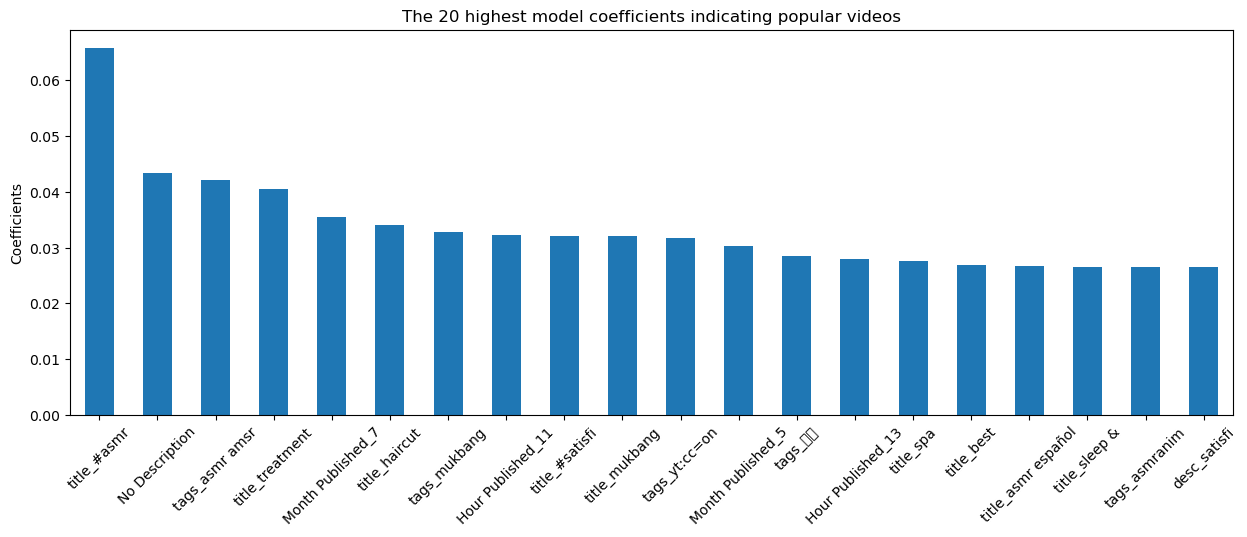

In [677]:
top_coeffs.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating popular videos")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12455 (\N{KATAKANA LETTER SMALL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12481 (\N{KATAKANA LETTER TI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


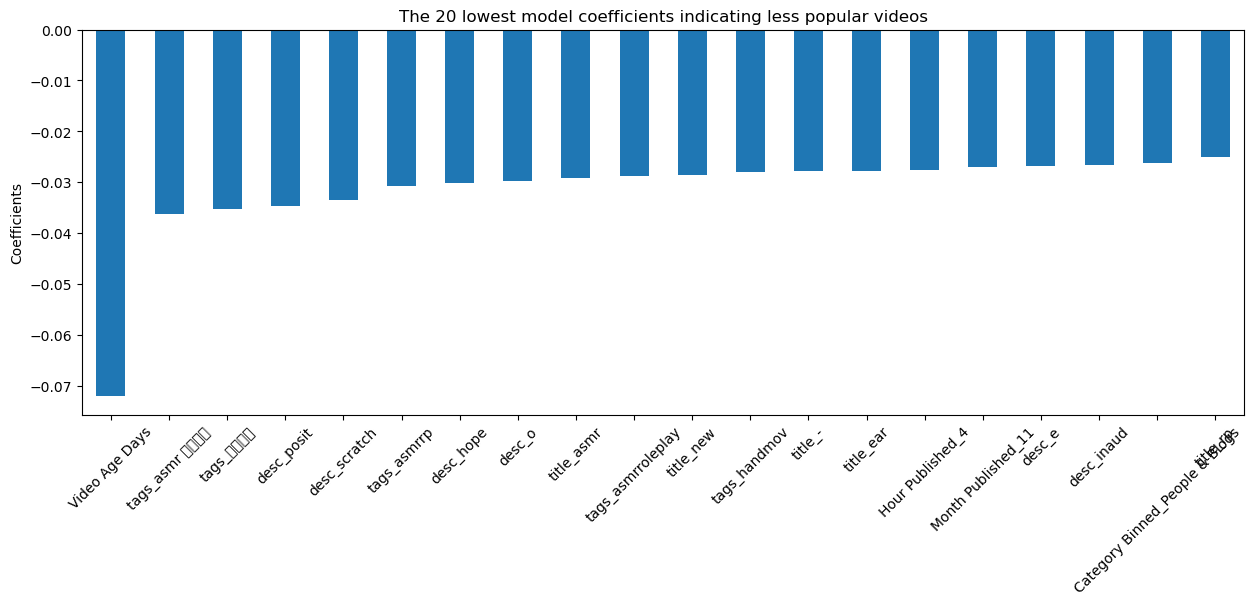

In [678]:
top_coeffs.sort_values("coefficients", ascending=True).head(20).plot(kind="bar",
                                                                     figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating less popular videos")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

### Top Coefficients Words

In [666]:
#find the words
words = top_coeffs.loc[(top_coeffs.index.str.contains(pat='title_|desc_|tags_'))]

/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54021 (\N{HANGUL SYLLABLE TING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jtumambing/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


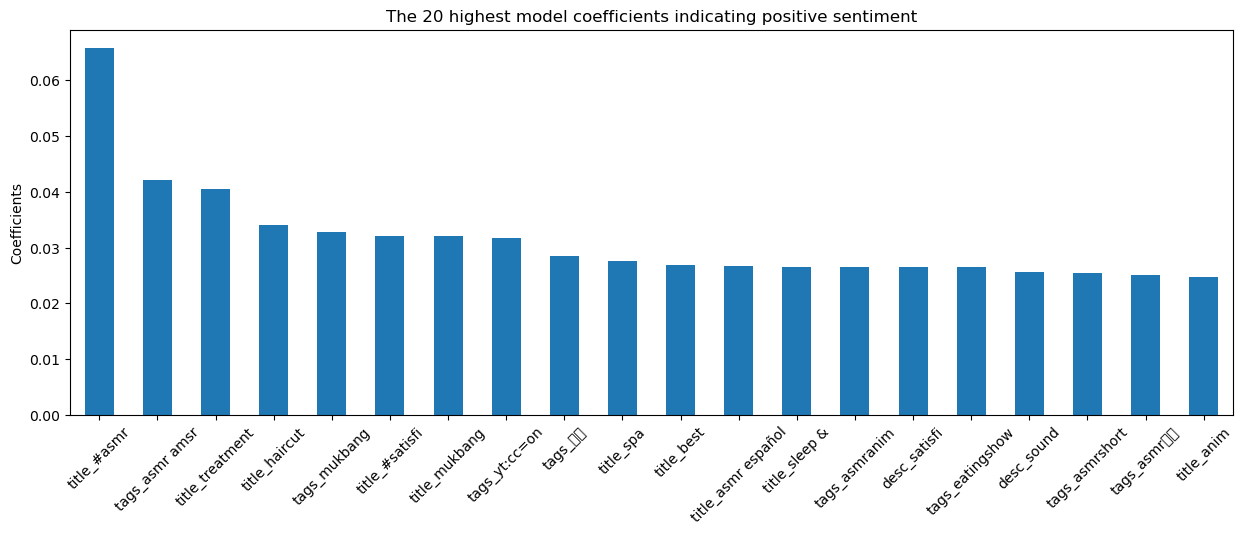

In [667]:
words.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

### Top Coefficients Non Words

In [668]:
#find the non words
nonwords = top_coeffs.loc[~(top_coeffs.index.str.contains(pat='title_|desc_|tags_'))]

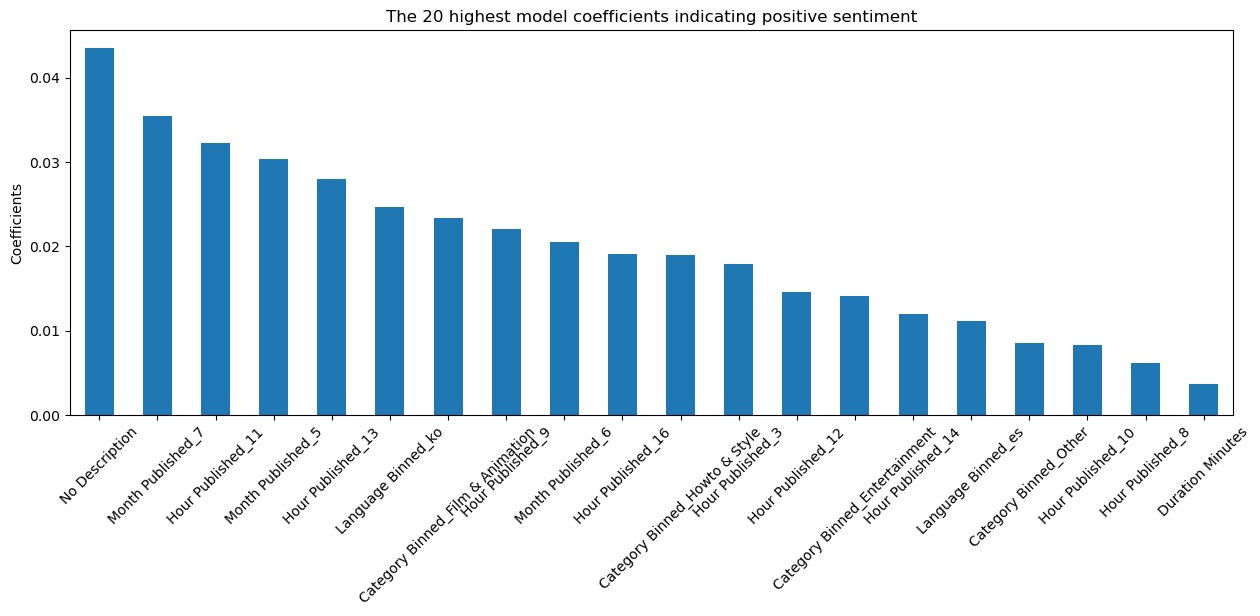

In [669]:
nonwords.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [670]:
#didn't group en together - should I?

### Odds Ratio

In [671]:
best_model.coef_[0].shape

(1048,)

In [672]:
X_train_all.columns

Index(['Duration Minutes', 'Video Age Days', 'No Description',
       'Month Published', 'Tag Count', 'Hour Published',
       'Category Binned_Entertainment', 'Category Binned_Film & Animation',
       'Category Binned_Gaming', 'Category Binned_Howto & Style',
       ...
       'tags_バイノーラル', 'tags_囁き', 'tags_最強', 'tags_最強 таппинг', 'tags_眠れる',
       'tags_眠れる 最強', 'tags_睡眠', 'tags_耳かき', 'tags_音フェチ', 'tags_먹방'],
      dtype='object', length=1048)

In [673]:
# Get log-odds (coefficients)
log_odds = best_model.coef_[0]



# Create a DataFrame for better visualization
feature_names = X_train_all.columns  # Assuming X_train is a DataFrame with named columns
#log_odds_df = pd.DataFrame({'Feature': feature_names, 'Log-Odds': log_odds})
dds_ratio_df = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': np.exp(log_odds)})
dds_ratio_df.set_index("Feature",inplace=True)
means = dds_ratio_df["stds"] = X_train_all[feature_names].mean(axis=0)
stds = dds_ratio_df["stds"] = X_train_all[feature_names].std(axis=0)



/var/folders/jq/w32h2r7j14xcg2xyk0zy25lh0000gp/T/ipykernel_12036/484673339.py:12: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stds = dds_ratio_df["stds"] = X_train_all[feature_names].std(axis=0)


In [674]:
dds_ratio_df["means"] = means
dds_ratio_df["stds"] = stds

In [675]:
dds_ratio_df.sort_values(by='Odds Ratio', ascending = False)

,Odds Ratio,stds,means
Feature,,,
title_#asmr,1.067978,0.307665,0.105769
No Description,1.044408,0.312735,0.109776
tags_asmr amsr,1.043034,0.101570,0.010417
title_treatment,1.041316,0.128674,0.016827
Month Published_7,1.036083,0.257452,0.071314
...,...,...,...
desc_scratch,0.967135,0.513376,0.071314
desc_posit,0.965902,0.194292,0.027244
tags_音フェチ,0.965364,0.137390,0.019231
